In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
import pandas as pd
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling
from sklearn import model_selection
#from preprocess.imageSteeringDB import ImageSteeringDB
import cv2
import random

local_project_path = r'C:/Users/Ketan/Thesis/PilotNet/src/driving_dataset/'
local_data_path = os.path.join(local_project_path, 'C:/Users/Ketan/Thesis/PilotNet/src/driving_dataset')
from tensorflow.keras.utils import Sequence
import matplotlib.image as mpimg

import os, json
import matplotlib.pyplot as plt

from PIL import Image
import skimage 
from skimage.transform import resize

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image

from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions




In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [3]:
dataset = ('C:/Users/Ketan/Thesis/PilotNet/src/driving_dataset')

In [4]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./driving_dataset/481.jpg')


In [5]:
#plt.imshow(img)

In [6]:
# img1 = Image.open('./driving_dataset/481.jpg')

In [7]:
# img1 = np.array(img1)

In [8]:
#plt.imshow(img1)

In [9]:
# Read the data
df = pd.io.parsers.read_csv(os.path.join(dataset, 'data_new.csv'))
# Split data into training and validation sets
df_train, df_valid = model_selection.train_test_split(df, test_size=.2)

In [10]:
x_train = df['image']
y_train = df['angle']

In [11]:
df['angle'].describe()


count    45405.000000
mean         1.745390
std         30.915841
min       -159.900000
25%         -5.450000
50%          1.010000
75%          8.870000
max        501.780000
Name: angle, dtype: float64

In [12]:
#df_train['angle'].nlargest(20)


In [13]:
# q_low = df["angle"].quantile(0.01)
# q_hi  = df["angle"].quantile(0.99)
# q_low, q_hi

In [14]:
# cats, bins1 = pd.cut(df.angle, 5, retbins=True)


In [15]:
import seaborn as sns
sns.set_style('whitegrid')
hist = df.hist(bins=20)

ModuleNotFoundError: No module named 'seaborn'

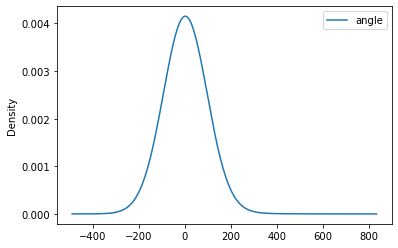

In [16]:
ax = df.plot.kde(bw_method=3)


In [17]:
pd.options.mode.chained_assignment = None #default = warn

In [18]:
df_train['angle_range'] = pd.qcut(df_train['angle'], q=10)
df_valid['angle_range'] = pd.qcut(df_valid['angle'], q=10)

In [19]:
df_train['labels']= df_train['angle_range'].cat.codes
df_valid['labels']= df_valid['angle_range'].cat.codes

In [20]:
df_train['labels'] = df_train['labels'].apply(str)
df_valid['labels'] = df_valid['labels'].apply(str)


In [21]:
df_train.angle_range

11099          (1.01, 2.42]
32126         (11.6, 22.08]
35259    (-159.901, -18.76]
6085        (-18.76, -9.48]
21507          (2.42, 6.35]
                ...        
26601    (-159.901, -18.76]
11122          (1.01, 2.42]
44955         (11.6, 22.08]
40999          (2.42, 6.35]
25450          (-2.32, 0.0]
Name: angle_range, Length: 36324, dtype: category
Categories (10, interval[float64, right]): [(-159.901, -18.76] < (-18.76, -9.48] < (-9.48, -2.32] < (-2.32, 0.0] ... (2.42, 6.35] < (6.35, 11.6] < (11.6, 22.08] < (22.08, 501.78]]

In [22]:
datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=dataset, x_col="image", y_col="labels", 
                                            class_mode="categorical", target_size=(256,455), batch_size=32)

Found 36324 validated image filenames belonging to 10 classes.


In [23]:
# ab = next(train_generator)
# ab

In [24]:
valid_generator=datagen.flow_from_dataframe(dataframe=df_valid, directory=dataset, 
                                            x_col="image", y_col="labels", class_mode="categorical", target_size=(256,455), 
                                            batch_size=32)

Found 9081 validated image filenames belonging to 10 classes.


In [25]:
model = models.Sequential()
model.add(convolutional.Convolution2D(16,3,3, input_shape=(256,455,3), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(convolutional.Convolution2D(32, 3, 3, activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(convolutional.Convolution2D(64, 3, 3, activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(core.Flatten())
model.add(core.Dense(500, activation='relu'))
model.add(core.Dropout(.5))
model.add(core.Dense(100, activation='relu'))
model.add(core.Dropout(.25))
model.add(core.Dense(20, activation='relu'))
model.add(core.Dense(10, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), loss='categorical_crossentropy',metrics=['AUC', 'categorical_accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 85, 151, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 76, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 13, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [ ]:
reconstructed_model = models.load_model("model_full.h5")


In [27]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [28]:



# checkpoint_filepath = 'C:/Users/Ketan/Thesis/PilotNet/src/model.h5'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='categorical_accuracy',
#     mode='max',
#     save_best_only=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20, callbacks=[callback])

C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
 144/1135 [==>...........................] - ETA: 5:52 - loss: 2.3039 - auc: 0.5004 - categorical_accuracy: 0.1018

KeyboardInterrupt: 

In [ ]:
# backend.clear_session()

In [ ]:
model.save_weights('model.h5')

In [ ]:
model.save('model_full.h5')

In [ ]:
reconstructed_model.save_weights('model_acc70')

In [ ]:
reconstructed_model.save('model_acc70.h5')

In [ ]:
reconstructed_model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)

In [ ]:
reconstructed_model.metrics_names

In [28]:
model1 = models.Sequential()
model1.add(convolutional.Convolution2D(16,3,3, input_shape=(455, 256, 3), activation='relu'))
model1.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model1.add(convolutional.Convolution2D(32, 3, 3, activation='relu'))
model1.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model1.add(convolutional.Convolution2D(64, 3, 3, activation='relu'))
model1.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model1.add(core.Flatten())
model1.add(core.Dense(500, activation='relu'))
model1.add(core.Dropout(.5))
model1.add(core.Dense(100, activation='relu'))
model1.add(core.Dropout(.25))
model1.add(core.Dense(20, activation='relu'))
model1.add(core.Dense(10, activation='softmax'))
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), loss='mean_squared_error',metrics='accuracy')

In [30]:
import keras


In [86]:
class RestoreCkptCallback(keras.callbacks.Callback):
    def __init__(self, pretrained_file):
        self.pretrained_file = pretrained_file
        self.sess = tf.compat.v1.keras.backend.get_session()
        self.saver =  tf.compat.v1.train.Saver(var_list = ['C:/Users/Ketan/Thesis/PilotNet/logs/checkpoint/model.ckpt'])
    def on_train_begin(self, logs=None):
#           if self.pretrain_model_path:
        self.saver.restore(self.sess, self.pretrained_file)
        print('load weights: OK.')

In [87]:
restore_ckpt_callback = RestoreCkptCallback('C:/Users/Ketan/Thesis/PilotNet/logs/checkpoint/model.ckpt') 


In [ ]:
model1.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1, callbacks=[restore_ckpt_callback])

In [39]:
PATH_REL_META = r'C:/Users/Ketan/Thesis/PilotNet/data/models/model.ckpt.meta'
    
# start tensorflow session
with tf.compat.v1.Session() as sess:
    
    # import graph
    saver = tf.compat.v1.train.import_meta_graph(PATH_REL_META)
    
    # load weights for graph
    saver.restore(sess, PATH_REL_META[:-5])
        
    # get all global variables (including model variables)
    vars_global = tf.compat.v1.global_variables()
    
    # get their name and value and put them into dictionary
    sess.as_default()
    model_vars = {}
    for var in vars_global:
        try:
            model_vars[var.name] = var.eval()
        except:
            print("For var={}, an exception occurred".format(var.name))

INFO:tensorflow:Restoring parameters from C:/Users/Ketan/Thesis/PilotNet/data/models/model.ckpt


In [91]:
model1.load_weights('C:/Users/Ketan/Thesis/PilotNet/data/models/model.ckpt', by_name=False, skip_mismatch=False, options=None)


AssertionError: Some objects had attributes which were not restored:
    <tf.Variable 'conv2d_6/kernel:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
array([[[[-1.49358004e-01, -1.27234906e-01,  1.57029122e-01,
          -1.86133415e-01, -1.40842289e-01, -5.18459827e-02,
           3.57145667e-02,  3.02916914e-02, -1.82501614e-01,
           1.52082592e-01, -9.73130763e-03,  4.03119773e-02,
          -6.91697747e-02, -4.10253406e-02,  3.28038037e-02,
           1.20863765e-01],
         [-1.44197226e-01,  1.17092431e-02,  4.81593460e-02,
          -1.59848645e-01,  1.07025415e-01, -3.86966765e-02,
           4.36441451e-02,  2.95090675e-02, -1.36027023e-01,
          -9.63330418e-02, -4.04241681e-02,  1.44060165e-01,
           9.25538838e-02,  6.13714904e-02,  5.93623519e-03,
           1.37779117e-01],
         [-6.78548515e-02,  1.36239201e-01,  1.56428456e-01,
          -8.76131058e-02,  5.80657572e-02, -4.27675694e-02,
           1.24737769e-01, -8.47871155e-02, -1.49074405e-01,
          -2.50726491e-02,  1.33098572e-01, -9.14871246e-02,
           5.24925739e-02,  8.97048712e-02, -1.55595466e-01,
           1.74680412e-01]],

        [[ 4.77194488e-02,  3.79978418e-02,  1.55441344e-01,
           4.08650041e-02,  6.34183288e-02,  4.83049452e-02,
          -1.99711025e-02, -1.45191312e-01, -1.13923497e-01,
           5.82723171e-02, -1.33744359e-01,  1.41889215e-01,
           1.35315001e-01,  7.45723248e-02,  4.89215553e-02,
           1.71303153e-01],
         [-1.40295297e-01, -8.47526863e-02, -1.55356526e-02,
          -1.54081807e-01,  1.58905625e-01, -8.26449692e-03,
           1.77915186e-01,  9.58142281e-02,  1.67646319e-01,
          -1.46881789e-01,  1.34195656e-01, -8.36265087e-03,
           4.08184677e-02, -1.12549938e-01, -2.95349211e-02,
           1.05911344e-02],
         [-1.01411849e-01, -8.22774544e-02,  5.22807240e-03,
           1.57680452e-01, -9.73872840e-02, -1.43818706e-02,
          -1.58192709e-01,  4.41404581e-02, -7.58391470e-02,
           1.52777106e-01, -1.09701157e-02, -7.64669329e-02,
          -7.89587349e-02,  6.75767660e-05, -8.59295651e-02,
          -7.48558342e-03]],

        [[-5.62504679e-02,  1.06717587e-01, -3.18891257e-02,
           5.90756536e-03, -1.32199079e-02,  1.73212767e-01,
          -2.46653408e-02,  6.62812293e-02,  1.17367536e-01,
           1.85137987e-02,  1.65325552e-01,  2.07186192e-02,
           1.29345953e-01, -9.97378230e-02,  2.98223644e-02,
           1.58849955e-01],
         [-1.76389918e-01, -2.11331248e-03,  1.95765793e-02,
          -4.49418724e-02,  7.08498955e-02,  5.02545238e-02,
           9.64189768e-02,  2.51410604e-02, -1.25240400e-01,
           3.78423333e-02, -9.77036506e-02,  5.92402369e-02,
          -5.30101806e-02,  2.87594497e-02,  6.94467127e-02,
          -1.10693127e-02],
         [-6.69341013e-02,  1.06196046e-01, -1.44265115e-01,
           3.09862345e-02, -1.23210654e-01,  4.86661941e-02,
           9.63897109e-02,  1.11613870e-01,  9.11276937e-02,
           1.60288006e-01,  1.13040209e-04, -1.27195120e-01,
           4.71338630e-04,  2.53972411e-03,  1.08773351e-01,
           1.22193158e-01]]],


       [[[ 8.19860101e-02,  9.53899026e-02, -2.82885134e-02,
           1.08014762e-01,  1.32744908e-01, -4.54452336e-02,
          -7.82043859e-02,  5.62103093e-03,  1.55982077e-01,
          -1.71752840e-01,  1.06980771e-01,  1.86271667e-01,
          -8.28438774e-02, -5.92824817e-03, -1.67628229e-02,
          -1.35031238e-01],
         [ 4.62865829e-02,  1.22836441e-01,  7.92105198e-02,
          -1.27496541e-01, -3.72655690e-03,  1.20160758e-01,
           6.59206510e-03,  1.73296541e-01, -6.50326163e-02,
           5.62815517e-02,  9.45040882e-02,  5.40335625e-02,
           1.58847123e-02,  1.29240274e-01,  7.45576918e-02,
           6.98560476e-03],
         [-1.88749284e-02,  1.76673949e-01, -1.41722888e-01,
           1.04459077e-02,  1.38350725e-01, -4.87454236e-03,
          -3.70409638e-02,  3.15770507e-02,  1.74687386e-01,
           1.36902988e-01,  1.35169804e-01,  3.45050395e-02,
          -1.32334799e-01,  4.92350757e-02, -1.73715770e-01,
           8.56576860e-03]],

        [[-1.28144950e-01,  1.93477869e-02,  1.83387995e-01,
          -8.13650563e-02,  1.66834742e-01,  1.84166372e-01,
          -1.64503232e-01,  1.50566131e-01,  9.16347206e-02,
          -6.74190670e-02, -1.31844312e-01, -1.78132638e-01,
          -1.50214970e-01, -6.21900558e-02, -7.35321119e-02,
           6.64994419e-02],
         [-6.94654211e-02, -1.31288603e-01, -7.30795264e-02,
           1.15170121e-01,  1.78932309e-01, -1.71061188e-01,
          -1.77796349e-01, -1.50555193e-01,  2.65180618e-02,
           6.84425831e-02, -9.83476937e-02, -1.39922559e-01,
          -4.11778539e-02,  1.77749097e-01, -1.84758961e-01,
           1.79967314e-01],
         [-6.18769079e-02,  3.82431597e-02,  7.89240003e-02,
           1.24250293e-01,  2.06826627e-02, -1.02272935e-01,
          -9.61107239e-02,  1.86765164e-01, -1.22811489e-01,
           4.71003354e-02, -8.63686576e-02, -3.27371806e-02,
          -1.20947562e-01, -5.03019542e-02, -1.86748102e-01,
           3.13469172e-02]],

        [[-1.18814826e-01,  4.14384007e-02, -7.95962065e-02,
           1.13649815e-01,  1.39315993e-01,  1.72143370e-01,
           1.40434444e-01, -1.60397246e-01, -1.25119984e-02,
          -1.29097015e-01,  4.64358330e-02,  1.69887424e-01,
          -1.62046760e-01, -5.80195785e-02,  4.14738059e-03,
           4.73707914e-02],
         [-1.10378355e-01,  1.82253540e-01, -7.41840899e-03,
          -1.83969289e-02,  8.07553530e-03, -9.84193236e-02,
           1.65506870e-01,  6.83501363e-02, -1.57939970e-01,
          -1.78275406e-01, -1.56927317e-01,  4.53659594e-02,
           1.31844789e-01,  7.62483776e-02, -1.29087120e-02,
          -5.67675084e-02],
         [ 1.01669848e-01,  1.32663697e-01,  1.75931066e-01,
          -1.57044008e-01, -1.13376997e-01, -7.51203075e-02,
           8.75204802e-04, -5.81935793e-02,  2.51714289e-02,
           3.30623388e-02,  7.02244639e-02, -1.84894323e-01,
          -9.56230387e-02,  2.83530504e-02, -1.22874990e-01,
           1.44442022e-01]]],


       [[[ 1.63515061e-01,  1.39781475e-01,  1.72746062e-01,
           1.07442319e-01,  8.45509470e-02, -1.74454004e-01,
          -5.73669225e-02,  1.06635034e-01,  1.17205739e-01,
          -1.75768167e-01, -5.48815578e-02,  2.01208889e-02,
           1.56121105e-02, -1.39837041e-01, -6.50804937e-02,
          -1.07426420e-01],
         [ 1.36847228e-01, -1.28627360e-01, -1.63748756e-01,
          -1.84489161e-01,  1.58473432e-01,  1.11093670e-01,
           6.87554181e-02, -1.76393718e-01,  1.52605921e-01,
           1.42504662e-01, -9.41358134e-02,  2.29095370e-02,
          -8.66731033e-02, -1.24628834e-01,  5.64991385e-02,
          -6.57691956e-02],
         [-5.70246130e-02,  5.32235205e-02, -9.34227332e-02,
           6.81172311e-02,  9.53015685e-02, -8.41491073e-02,
           1.57637298e-02, -1.00549780e-01,  6.38434291e-02,
          -8.94501880e-02, -1.27779499e-01,  6.35804534e-02,
          -5.80483079e-02,  5.74086905e-02,  1.54877633e-01,
           8.69415700e-03]],

        [[ 9.74609256e-02, -7.88629800e-02, -1.85736209e-01,
           7.44199753e-03,  1.30231231e-01, -5.42904437e-02,
           4.77877855e-02, -1.22910187e-01,  3.99414003e-02,
          -8.46390277e-02,  1.51463598e-02, -1.61910772e-01,
          -2.57891715e-02, -2.43932009e-03, -9.65981856e-02,
           1.25650257e-01],
         [ 4.54316586e-02,  1.60570890e-01,  1.95850581e-02,
           1.57456100e-02, -8.43311846e-02,  9.86044407e-02,
           1.09833062e-01,  8.73140693e-02, -1.55476585e-01,
           1.29293144e-01,  5.38165122e-02,  1.12037927e-01,
          -1.63285226e-01, -4.01335955e-03,  1.72652513e-01,
          -7.47301131e-02],
         [-2.90971696e-02,  1.01675212e-01,  9.88488197e-02,
          -3.12571526e-02, -2.06392556e-02,  1.45162165e-01,
           5.91379106e-02, -1.15658224e-01,  6.12531453e-02,
           1.26927286e-01,  5.16209900e-02,  4.60164845e-02,
          -1.12745322e-01,  9.83811319e-02,  1.84649795e-01,
           3.49324346e-02]],

        [[-2.69512236e-02,  4.52801287e-02, -5.39689809e-02,
           2.44844258e-02, -9.09317359e-02, -9.84951556e-02,
           9.53334570e-02,  1.32453650e-01,  1.45110428e-01,
           1.00763023e-01, -7.56298006e-03,  1.32401943e-01,
          -6.77273944e-02,  9.04261768e-02,  7.03189969e-02,
          -1.38430789e-01],
         [ 1.74807876e-01,  1.39447868e-01,  1.26208901e-01,
           1.41309381e-01,  2.77712643e-02,  1.78801686e-01,
           1.53786391e-01, -7.71661103e-03,  8.51521790e-02,
          -3.67085487e-02,  1.56818330e-03,  1.82590455e-01,
          -6.21174425e-02, -1.44343764e-01,  1.30288750e-01,
           1.69831216e-01],
         [-9.88665074e-02, -4.38005030e-02,  1.58247322e-01,
          -6.95459470e-02, -4.42293733e-02,  1.69684112e-01,
          -7.26480708e-02,  1.51315987e-01, -1.14692137e-01,
          -1.63999066e-01,  4.91854101e-02, -1.49233609e-01,
           3.55047435e-02, -8.69482756e-03, -4.63828295e-02,
          -1.33534819e-01]]]], dtype=float32)>: ['conv2d_6/kernel']
    <tf.Variable 'conv2d_6/bias:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['conv2d_6/bias']
    <tf.Variable 'conv2d_7/kernel:0' shape=(3, 3, 16, 32) dtype=float32, numpy=
array([[[[-4.24567610e-03, -6.60209358e-02,  9.69274715e-02, ...,
          -1.10115111e-02,  9.73987207e-02, -1.06986687e-01],
         [-1.17504515e-01,  4.19218466e-02, -5.31202853e-02, ...,
           1.13479048e-03,  6.11933395e-02, -1.09644495e-01],
         [-9.60090309e-02, -9.15749297e-02,  2.97764465e-02, ...,
          -9.98664796e-02,  5.56206629e-02, -9.94599015e-02],
         ...,
         [ 5.97254857e-02, -7.56619945e-02, -9.86597016e-02, ...,
          -6.16161078e-02, -2.92030722e-02, -1.01137713e-01],
         [ 5.26382700e-02,  5.24467304e-02,  8.36173818e-02, ...,
           5.81957474e-02,  6.44063726e-02, -1.11528173e-01],
         [-5.11880815e-02, -1.07965916e-02,  6.90409765e-02, ...,
           1.05169110e-01, -9.94650424e-02, -6.94870353e-02]],

        [[-4.89718542e-02,  7.01052472e-02,  2.64677778e-02, ...,
          -9.60692167e-02,  1.59986839e-02, -1.42198056e-03],
         [-9.06907171e-02,  5.41996136e-02,  2.29001269e-02, ...,
           8.10908452e-02, -6.49504811e-02,  1.11153997e-01],
         [ 1.31218061e-02, -7.34300911e-02,  3.68663594e-02, ...,
           3.29215750e-02,  1.24752447e-02,  8.23503658e-02],
         ...,
         [ 1.79185346e-02, -4.74546254e-02, -2.68692598e-02, ...,
           7.62861595e-02,  4.63578030e-02,  5.17169312e-02],
         [-4.85549420e-02,  8.27598944e-02,  3.02911326e-02, ...,
          -6.21881820e-02,  9.85516682e-02,  3.00727859e-02],
         [-1.08438864e-01, -8.35360140e-02,  9.18916240e-02, ...,
           8.48925784e-02,  2.13827938e-03,  7.76210055e-02]],

        [[ 6.61420003e-02,  4.65380773e-02,  2.58652344e-02, ...,
           2.53799036e-02,  1.02161691e-02,  1.90363005e-02],
         [ 6.16093054e-02,  4.59946916e-02,  3.88253108e-02, ...,
          -7.70469159e-02,  1.70587748e-03,  3.57206091e-02],
         [ 3.80276889e-03,  2.96540484e-02,  2.91369632e-02, ...,
          -1.13611862e-01, -7.69056380e-02,  1.98504850e-02],
         ...,
         [ 8.43594149e-02, -9.82521474e-03, -7.18996003e-02, ...,
          -1.05165549e-01,  3.57741937e-02,  6.81454763e-02],
         [-1.09825216e-01, -7.58418441e-03,  8.54824111e-02, ...,
          -7.35291094e-03, -9.28756371e-02, -3.53977606e-02],
         [-1.14424534e-01, -4.32350785e-02,  1.12204753e-01, ...,
          -4.73958477e-02,  3.03270742e-02,  5.61344102e-02]]],


       [[[-6.51987568e-02,  1.87759176e-02,  1.79599226e-03, ...,
           2.83398554e-02, -1.77156106e-02, -1.13898344e-01],
         [ 1.11863278e-01,  1.03126459e-01,  7.82071576e-02, ...,
          -1.03371665e-01, -1.14278644e-02, -1.94965973e-02],
         [-3.42538655e-02,  6.88766614e-02, -9.09239873e-02, ...,
          -4.70618457e-02,  1.38615295e-02, -5.20296916e-02],
         ...,
         [ 7.38436952e-02,  9.87530425e-02,  2.69503817e-02, ...,
          -6.18921146e-02,  1.17758885e-02, -4.11403924e-03],
         [ 2.54505649e-02,  1.04214735e-01, -8.57795030e-03, ...,
           2.26964727e-02, -2.32346281e-02,  8.02751109e-02],
         [ 2.94046178e-02,  9.92848203e-02,  7.46279582e-02, ...,
           1.17724411e-01, -7.31357634e-02, -5.76468855e-02]],

        [[ 1.49434134e-02, -8.21914077e-02, -7.08240420e-02, ...,
           1.30437240e-02,  6.01397082e-02,  5.55905700e-03],
         [ 5.89837506e-02,  3.76932696e-02, -1.16976134e-01, ...,
          -6.81290030e-03,  1.06290929e-01, -6.28247708e-02],
         [ 2.40297094e-02, -1.53288618e-02, -5.66635989e-02, ...,
           8.80286098e-05, -3.30076665e-02,  4.90466580e-02],
         ...,
         [ 8.54849815e-04,  5.80567122e-03, -1.95913166e-02, ...,
          -4.99379709e-02,  8.14065561e-02,  9.83459577e-02],
         [ 8.84078816e-02, -1.20749325e-02,  9.95456800e-02, ...,
          -7.89853632e-02, -1.13069318e-01,  5.65798953e-02],
         [-4.04501036e-02, -1.15847662e-02, -6.64039329e-02, ...,
          -6.92119524e-02, -2.50121281e-02, -3.98961529e-02]],

        [[ 1.36201158e-02,  1.08849607e-01, -7.78133422e-02, ...,
           4.35413793e-02, -1.14994980e-01,  6.50753081e-03],
         [-2.50571743e-02,  8.23125914e-02, -2.02695131e-02, ...,
           1.15243569e-02,  1.01250388e-01, -8.92664045e-02],
         [-2.86982656e-02,  4.01624665e-02, -8.27993378e-02, ...,
           1.38943866e-02, -6.11681417e-02,  8.11478570e-02],
         ...,
         [-2.43823156e-02, -2.14929804e-02, -4.70896661e-02, ...,
          -5.72265983e-02, -6.51533902e-03,  6.84678331e-02],
         [-2.60233209e-02, -1.94536150e-03, -7.13307858e-02, ...,
          -9.07494128e-02, -1.00108713e-01, -7.02557042e-02],
         [-7.78661892e-02, -1.94449574e-02,  1.12190448e-01, ...,
           7.43856207e-02, -6.33937791e-02, -3.02823111e-02]]],


       [[[ 1.84710324e-03,  4.74766269e-02,  1.14560284e-01, ...,
           4.92922887e-02, -5.16816452e-02, -5.17901629e-02],
         [ 3.19741443e-02, -8.26989710e-02, -2.68938169e-02, ...,
           1.12781040e-01,  1.07401386e-02, -2.33836025e-02],
         [-8.53490531e-02,  6.16182759e-02, -1.17670685e-01, ...,
          -8.58070701e-03, -5.02607897e-02,  1.91124752e-02],
         ...,
         [ 5.46673015e-02,  1.11807026e-01,  9.29087624e-02, ...,
           2.11374536e-02, -1.10967793e-01, -9.88773480e-02],
         [ 1.03945874e-01,  7.67004415e-02,  4.65434715e-02, ...,
           2.48424783e-02,  2.57749334e-02,  3.00405920e-03],
         [-8.02994668e-02,  5.12865558e-02,  1.56572461e-03, ...,
           1.89014524e-03,  9.92203429e-02,  3.18649635e-02]],

        [[ 9.29546729e-02,  4.97486517e-02, -1.02204755e-01, ...,
           5.92114404e-02, -8.12560320e-03, -5.90024404e-02],
         [-2.65785903e-02,  9.78150740e-02,  5.35716787e-02, ...,
          -3.14371064e-02,  8.14191923e-02, -9.80840921e-02],
         [-6.30242378e-02, -8.53866190e-02, -3.21849883e-02, ...,
           5.35101667e-02,  6.63016513e-02, -1.20548680e-02],
         ...,
         [ 6.71289936e-02, -2.24103034e-03, -1.90292150e-02, ...,
           1.90070793e-02,  8.50191787e-02, -7.55040273e-02],
         [-1.01095341e-01, -9.40231308e-02,  3.51231620e-02, ...,
           6.18496910e-02,  1.01601042e-01, -8.06765407e-02],
         [ 5.03207743e-03, -6.10561185e-02, -9.30665657e-02, ...,
          -1.03734747e-01, -1.11262143e-01, -8.97677541e-02]],

        [[-3.79825681e-02, -4.23980132e-02,  4.36350331e-02, ...,
           6.42342642e-02,  6.28672168e-02, -3.52333859e-02],
         [ 7.53564611e-02,  9.66851786e-02,  1.37292817e-02, ...,
          -3.64351273e-03,  2.27639899e-02,  1.19707659e-02],
         [ 2.89485082e-02,  6.94580302e-02, -1.09280571e-01, ...,
          -2.32324973e-02,  1.01896450e-02, -1.48559213e-02],
         ...,
         [-1.30943507e-02, -1.54639855e-02, -1.30865127e-02, ...,
           1.90277025e-02,  9.53700319e-02,  4.23870310e-02],
         [-6.21774197e-02, -2.21115574e-02, -1.13504007e-02, ...,
          -7.22770393e-02,  1.39825270e-02, -3.85994613e-02],
         [ 9.86536965e-02, -1.09774023e-01,  4.30083275e-03, ...,
           7.87651762e-02,  1.04281805e-01,  3.38012949e-02]]]],
      dtype=float32)>: ['conv2d_7/kernel']
    <tf.Variable 'conv2d_7/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['conv2d_7/bias']
    <tf.Variable 'conv2d_8/kernel:0' shape=(3, 3, 32, 64) dtype=float32, numpy=
array([[[[ 0.07119624, -0.03438862,  0.06845544, ...,  0.0054031 ,
          -0.06921773,  0.0402654 ],
         [ 0.01600637,  0.02535894,  0.02568763, ...,  0.07625892,
          -0.04872652,  0.01710862],
         [ 0.02940156,  0.00449836, -0.07689448, ...,  0.06271357,
          -0.01114085, -0.03551197],
         ...,
         [ 0.05176339,  0.05655583, -0.07800999, ..., -0.02805668,
           0.05233987, -0.0820049 ],
         [-0.04674419, -0.01261926,  0.05927809, ...,  0.0501013 ,
          -0.07136679,  0.01947936],
         [ 0.04868486,  0.08021504,  0.01646181, ..., -0.07344913,
          -0.0600132 ,  0.06798055]],

        [[-0.05297134, -0.03738592, -0.03398744, ..., -0.04725478,
           0.04538453, -0.07518481],
         [-0.05813889,  0.07116605,  0.06993795, ...,  0.02761861,
           0.00677747,  0.02989125],
         [ 0.04890639, -0.00113237, -0.04538461, ...,  0.07410262,
          -0.06649353, -0.02349415],
         ...,
         [-0.0145913 ,  0.0431327 ,  0.01013174, ..., -0.07050996,
          -0.03192363, -0.05990511],
         [ 0.02766152, -0.03430953, -0.01196352, ...,  0.06193224,
           0.04746241, -0.06789573],
         [-0.04223289, -0.07407161,  0.01543919, ..., -0.01173433,
           0.03393843, -0.0538883 ]],

        [[ 0.02297064, -0.01049364,  0.07862569, ..., -0.08225106,
          -0.07908504,  0.08185235],
         [-0.0805284 ,  0.03860077, -0.0565986 , ..., -0.02504188,
           0.04234413,  0.07755431],
         [ 0.00510019,  0.0824404 ,  0.04736414, ..., -0.07230377,
           0.04512603, -0.05457159],
         ...,
         [ 0.00746745, -0.00272866,  0.04704843, ..., -0.00613882,
           0.06085352,  0.07503273],
         [ 0.01524357, -0.06090442,  0.04066825, ...,  0.08269597,
          -0.04087357, -0.05722984],
         [ 0.05764339,  0.05443419,  0.00925728, ...,  0.04399431,
           0.07067265, -0.07091022]]],


       [[[ 0.03013591, -0.02354803,  0.07262913, ...,  0.0158411 ,
           0.0626675 , -0.00745833],
         [ 0.0478401 , -0.06447929, -0.0819637 , ..., -0.05153932,
          -0.06344239, -0.03705001],
         [ 0.0509002 , -0.01398102,  0.06774459, ...,  0.059391  ,
           0.00030696, -0.037024  ],
         ...,
         [ 0.0319435 , -0.05038575,  0.0456505 , ..., -0.08257823,
          -0.0457382 ,  0.01420756],
         [ 0.0549802 ,  0.04136523, -0.07558393, ..., -0.04435561,
          -0.07123586, -0.05300423],
         [-0.04186535, -0.02335765,  0.07966188, ..., -0.01894442,
          -0.03201479,  0.02763411]],

        [[-0.07993637,  0.0426937 , -0.03011118, ..., -0.0452288 ,
           0.0056116 , -0.00243875],
         [-0.0081658 ,  0.0187782 ,  0.05532732, ...,  0.00401213,
          -0.05112976,  0.0479931 ],
         [ 0.02966591,  0.04905165,  0.02482346, ..., -0.04900181,
           0.04744806,  0.01393634],
         ...,
         [-0.04858565,  0.04562093, -0.04564448, ..., -0.07588121,
          -0.04650835,  0.01057062],
         [-0.01710013, -0.04519757,  0.06633771, ..., -0.00905528,
           0.0570747 , -0.07671668],
         [-0.0786541 ,  0.01827302, -0.00339836, ..., -0.04999032,
           0.04345918, -0.07728738]],

        [[-0.03719739,  0.04753164,  0.07963511, ..., -0.05540721,
          -0.02038296, -0.05312691],
         [ 0.07594378, -0.06033079, -0.03534178, ..., -0.06198041,
           0.01921906,  0.03628389],
         [ 0.08129295,  0.07138857,  0.05636755, ..., -0.05878518,
           0.06277425, -0.05514036],
         ...,
         [-0.02389359, -0.00793731,  0.04238731, ...,  0.06741246,
           0.07830129,  0.01780979],
         [-0.02953349, -0.0303697 , -0.06443703, ...,  0.06532434,
           0.00525848,  0.05699303],
         [ 0.01224754, -0.02935998, -0.02652284, ..., -0.02459075,
           0.03751417,  0.03178811]]],


       [[[ 0.01247869, -0.00944569, -0.05772331, ...,  0.06931234,
           0.0366197 ,  0.05396251],
         [ 0.02325302, -0.05291758, -0.02519663, ..., -0.00108007,
           0.00037456,  0.0298752 ],
         [-0.03216255,  0.0287613 ,  0.06898866, ...,  0.07572643,
          -0.06994121,  0.02994641],
         ...,
         [ 0.01512036, -0.04926298,  0.0819448 , ...,  0.02721437,
           0.07422764,  0.02713295],
         [-0.03486806,  0.00235754,  0.02882693, ..., -0.03696686,
          -0.03813475,  0.07772876],
         [ 0.01626859, -0.00144085,  0.03178922, ..., -0.07857203,
           0.02294675, -0.02607825]],

        [[ 0.06527457,  0.07631806,  0.05949   , ...,  0.00997671,
           0.06337718,  0.04236043],
         [ 0.05358071, -0.03868606, -0.06674694, ..., -0.05287951,
           0.04632068,  0.01883934],
         [ 0.03901813, -0.02407195,  0.02513003, ...,  0.05092046,
           0.06041927, -0.07160401],
         ...,
         [ 0.05237574,  0.02626928, -0.00508088, ..., -0.06359389,
          -0.0446053 ,  0.07096186],
         [-0.05809715,  0.0162003 ,  0.00749612, ...,  0.06453995,
           0.03600115, -0.0028711 ],
         [-0.03458168, -0.04998728,  0.04538731, ...,  0.03335056,
          -0.05322093, -0.00828221]],

        [[ 0.06541712,  0.06674067,  0.05157445, ..., -0.04872964,
          -0.04134464, -0.04871438],
         [-0.06142366, -0.0455906 ,  0.03726248, ...,  0.06223682,
           0.00945833,  0.08110184],
         [ 0.05886609,  0.00160199,  0.04744724, ..., -0.02320461,
           0.04090798,  0.00213226],
         ...,
         [ 0.06823488,  0.07761053,  0.05872185, ...,  0.01545552,
           0.05461908,  0.02984961],
         [-0.03236502, -0.0668425 , -0.0596631 , ..., -0.04766577,
           0.04053738, -0.06190612],
         [-0.01557323, -0.03806563, -0.07126676, ...,  0.02216158,
           0.07797066,  0.0153422 ]]]], dtype=float32)>: ['conv2d_8/kernel']
    <tf.Variable 'conv2d_8/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['conv2d_8/bias']
    <tf.Variable 'dense_8/kernel:0' shape=(128, 500) dtype=float32, numpy=
array([[-0.04360266,  0.07029684, -0.00494394, ..., -0.01747312,
         0.0957206 ,  0.05287308],
       [ 0.01132647, -0.09770886,  0.00333454, ...,  0.04442731,
         0.04831651, -0.08128314],
       [ 0.0637182 ,  0.01632655,  0.0524279 , ..., -0.09260301,
         0.08353239,  0.01511744],
       ...,
       [ 0.04875481, -0.08615816, -0.06090309, ...,  0.02932328,
        -0.0854316 , -0.06964514],
       [-0.01662032,  0.0080734 ,  0.08994189, ...,  0.0487289 ,
         0.07684144,  0.05239604],
       [-0.0935895 , -0.01340459,  0.00362992, ..., -0.06663552,
        -0.09574957, -0.05823239]], dtype=float32)>: ['dense_8/kernel']
    <tf.Variable 'dense_8/bias:0' shape=(500,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['dense_8/bias']
    <tf.Variable 'dense_9/kernel:0' shape=(500, 100) dtype=float32, numpy=
array([[-0.05390651,  0.01746146,  0.04528799, ..., -0.02897491,
        -0.08510559,  0.05154958],
       [ 0.02288983, -0.03517   ,  0.02764016, ...,  0.05209503,
        -0.02435897,  0.03911167],
       [ 0.06775393,  0.02574835, -0.03675587, ..., -0.04609959,
         0.02506294,  0.01594112],
       ...,
       [-0.00771189, -0.07814977, -0.03148882, ..., -0.00969772,
         0.08526056,  0.04760895],
       [ 0.02871781, -0.02585087, -0.06831656, ..., -0.03048575,
         0.04927497,  0.04903979],
       [-0.06604309,  0.03018258,  0.01747198, ...,  0.09447541,
        -0.06909163,  0.09245778]], dtype=float32)>: ['dense_9/kernel']
    <tf.Variable 'dense_9/bias:0' shape=(100,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['dense_9/bias']
    <tf.Variable 'dense_10/kernel:0' shape=(100, 20) dtype=float32, numpy=
array([[-0.17522167,  0.03118604,  0.04417786, ...,  0.12881157,
        -0.1739305 ,  0.20991796],
       [-0.14761585, -0.15213153, -0.17406671, ..., -0.18267393,
        -0.0060571 ,  0.03131744],
       [ 0.11546129, -0.13594538,  0.06201756, ..., -0.00236695,
         0.0434373 , -0.18000178],
       ...,
       [ 0.00564601, -0.09205955,  0.06775233, ..., -0.18727306,
        -0.17397827,  0.08093548],
       [ 0.04927695, -0.18004993,  0.05818352, ..., -0.04310377,
        -0.21755481,  0.08514541],
       [-0.02462295, -0.20094758,  0.17172956, ...,  0.02395314,
         0.10863569,  0.12800118]], dtype=float32)>: ['dense_10/kernel']
    <tf.Variable 'dense_10/bias:0' shape=(20,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>: ['dense_10/bias']
    <tf.Variable 'dense_11/kernel:0' shape=(20, 10) dtype=float32, numpy=
array([[ 0.23146486, -0.43191624,  0.12788123, -0.3035344 ,  0.24266446,
        -0.09198073, -0.27175915,  0.06763875,  0.12527758,  0.25670183],
       [-0.2561878 , -0.3386777 , -0.24520253, -0.26107854, -0.41599247,
        -0.24399747, -0.05953524, -0.41727793,  0.15815544, -0.2655528 ],
       [-0.03064269,  0.38847667, -0.16536129, -0.33758277,  0.11738133,
         0.30864477,  0.07935357, -0.14229125,  0.39432883,  0.31049854],
       [-0.19130397,  0.22285008,  0.24634022,  0.4155295 ,  0.01176715,
         0.03385761,  0.15529299, -0.01606527,  0.09073716, -0.1606017 ],
       [ 0.4174803 ,  0.27669114, -0.00056627, -0.04959872,  0.14662242,
         0.11615747, -0.10530594,  0.22620916,  0.21559006,  0.2662934 ],
       [-0.12595284,  0.38732874,  0.16427606,  0.30373687, -0.36128497,
        -0.17787874, -0.3366807 , -0.22803137,  0.18265861,  0.27677548],
       [-0.19776753, -0.21844587,  0.28721774, -0.09332022, -0.37992498,
        -0.39500353, -0.15991706,  0.04275805, -0.14319393,  0.12092084],
       [ 0.00049835,  0.08938539,  0.433496  , -0.22219999, -0.25244933,
        -0.28975338,  0.07638532, -0.35183382,  0.13714588,  0.11295068],
       [-0.34169108, -0.11251384,  0.35204738, -0.41395265,  0.2238015 ,
        -0.37878102,  0.19561833, -0.08551258,  0.16081792,  0.39584994],
       [ 0.22902018,  0.04920626,  0.44335425,  0.31129974,  0.00282031,
        -0.05900308, -0.42431906,  0.25000453, -0.05697551, -0.37911272],
       [-0.09666246,  0.10818833,  0.39904565,  0.00908297, -0.01879695,
        -0.22813213, -0.02558848,  0.33057332,  0.3049283 , -0.04827756],
       [ 0.07761389, -0.419064  , -0.44055706,  0.27952915, -0.1250011 ,
        -0.03560719, -0.19736268, -0.14273098,  0.23560661, -0.32492286],
       [ 0.32515645,  0.2858072 , -0.34606224, -0.10578915, -0.15091395,
        -0.38866282,  0.17866105, -0.3463606 , -0.44249368,  0.11064208],
       [-0.24575622,  0.1854018 ,  0.3765456 ,  0.24941611, -0.14913994,
         0.07637894, -0.0489575 , -0.30011785,  0.1143319 ,  0.07727277],
       [-0.1160627 ,  0.18902946, -0.44274914,  0.21558249,  0.42646092,
         0.3623926 ,  0.15445727,  0.39297277, -0.40865323,  0.06777388],
       [-0.38734856,  0.10943729, -0.21539003,  0.01348987, -0.4356386 ,
         0.35607886,  0.1297012 ,  0.43790883, -0.17765513,  0.02446532],
       [ 0.19381338, -0.30180806,  0.19629812,  0.2799849 , -0.02931458,
        -0.20912331, -0.0414162 ,  0.25888067,  0.2073834 , -0.14172968],
       [-0.10506797, -0.35381764,  0.4049366 , -0.11028838, -0.22153531,
        -0.13302478,  0.06010652, -0.23737207, -0.08113629, -0.22221333],
       [ 0.03975007,  0.20984966, -0.4118287 ,  0.21127927, -0.44081455,
         0.20686364, -0.31548804, -0.42129478, -0.206073  ,  0.25368834],
       [ 0.31931126, -0.0598805 , -0.17157012, -0.38193452,  0.27272624,
        -0.30221397, -0.03749093,  0.3690616 ,  0.2890054 ,  0.11931175]],
      dtype=float32)>: ['dense_11/kernel']
    <tf.Variable 'dense_11/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['dense_11/bias']

In [ ]:
def append_ext(fn):
    return fn+".jpg"

In [ ]:
test_data_path = 'C:/Users/Ketan/Thesis/self-driving-car/challenges/challenge-2'
testdf=pd.DataFrame({'id':[], 'prediction':[]})
testdf.to_csv(index = False, header = True)

In [ ]:
testdf["id"]=testdf["id"].apply(append_ext)


In [ ]:
df_test = pd.read_csv('./testdf1.csv',dtype=str)


In [ ]:
df_test

In [ ]:
df_test["frame_id"]=df_test["frame_id"].apply(append_ext)

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)


In [ ]:
test_generator=test_datagen.flow_from_dataframe(dataframe=df_test, directory=test_data_path,batch_size=32,
                                                seed=42,shuffle=False, class_mode=None,target_size=(640,480))

In [ ]:
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


In [ ]:
predictions = reconstructed_model.predict_generator(test_data_generator, steps=test_steps_per_epoch)


In [ ]:
# Cameras we will use
# cameras = ['left', 'center', 'right']
# cameras_steering_correction = [.25, 0., -.25]

def preprocess(image, top_offset=.1, bottom_offset=.1):
    """
    Applies preprocessing pipeline to an image: crops `top_offset` and `bottom_offset`
    portions of image, resizes to 32x128 px (from 160×320 in original repo) and scales pixel values to [0, 1].
    """
    top = int(top_offset * image.shape[0])
    bottom = int(bottom_offset * image.shape[0])
    image = skimage.transform.resize(image[top:-bottom, :], (455, 256, 3), mode='constant')
    return image

def generate(data, root_path, augment=True):
    """
    Keras generator yielding batches of training/validation data.
    Applies data augmentation pipeline if `augment` is True.
    """
    #print('hello')
    while True:
        # Generate random batch of indices
        indices = np.random.permutation(data.count()[0])
        batch_size = 128
        for batch in range(0, len(indices), batch_size):
            batch_indices = indices[batch:(batch + batch_size)]
            # Output arrays
            x = np.empty([0, 455, 256, 3], dtype=np.float32)
            y = np.empty([0], dtype=np.float32)
            # Read in and preprocess a batch of images
            for i in batch_indices:
                # Randomly select camera
                #camera = np.random.randint(len(cameras)) if augment else 1
                # Read frame image and work out steering angle
                
                #print(data.values[1])
                image = Image.open(root_path + data.values[i][0])#.clip(' '))
                image = np.array(image)
                #print(image)
                angle = data.angle.values[i]
                if augment:
                    # Add random shadow as a vertical slice of image
                    #print( image.shape[0])
                    h, w = image.shape[0], image.shape[1]
                    [x1, x2] = np.random.choice(w, 2, replace=False)
                    k = h / (x2 - x1)
                    b = - k * x1
                    for i in range(h):
                        c = int((i - b) / k)
                        image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
                # Randomly shift up and down while preprocessing
                v_delta = .05 if augment else 0
                image = preprocess(
                    image,
                    top_offset=random.uniform(.375 - v_delta, .375 + v_delta),
                    bottom_offset=random.uniform(.125 - v_delta, .125 + v_delta)
                )
                # Append to batch
                x = np.append(x, [image], axis=0)
                y = np.append(y, [angle])
            # Randomly flip half of images in the batch
            flip_indices = random.sample(range(x.shape[0]), int(x.shape[0] / 2))
            x[flip_indices] = x[flip_indices, :, ::-1, :]
            y[flip_indices] = -y[flip_indices]
            yield (x, y)

In [ ]:
#generate(df_train, local_project_path)

In [ ]:
history = model.fit_generator(
    generate(df_train, local_project_path), steps_per_epoch=df_train.shape[0], epochs=1, 
    validation_data=generate(df_valid, local_project_path, augment=False), validation_steps=df_valid.shape[0],
)

In [ ]:
model.fit(
    x=generate(df_train, local_project_path), y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)